In [19]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random

In [20]:
rows = 3
columns = 4
terminal_state_win = (0, 3)
terminal_state_lose = (1, 3)
starting_state = (2,0)
dis_factor = 0.9
tol = 0.05

In [21]:
class GridWorld:
    def __init__(self):
        self.cur_state = starting_state
        self.board = np.zeros([rows, columns], np.int8)
        self.board[1, 1] = -1
        self.is_terminal = False

    def state_is_terminal(self, state):
        if (state == terminal_state_win) or (state == terminal_state_lose):
            self.is_terminal = True
            return self.is_terminal

    def reward(self, state):
        if state == terminal_state_win:
            return 1
        if state == terminal_state_lose:
            return -1
        else:
            return 0

    def update_position(self, state, action):
        if action == "Up":
            next_state = (state[0] - 1, state[1])
        elif action == "Down":
            next_state = (state[0] + 1, state[1])
        elif action == "Left":
            next_state = (state[0], state[1] - 1)
        elif action == "Right":
            next_state = (state[0], state[1] + 1)
        else:
            return state

        if (next_state[0] >= 0) and (next_state[0] <= 2):
            if (next_state[1] >= 0) and (next_state[1] <= 3):
                if next_state != (1, 1):
                    return next_state
        return state

    def init_state_value_function(self):
        # Init values with solution from linalg.solve done in Assignment 1
        state_value = np.array(
            [
                [0.0492, 0.1272, 0.2616, 0],
                [-0.0069, 0, -0.3371, 0],
                [-0.066, -0.1545, -0.3117, -0.5821],
            ]
        )
#         state_value = np.zeros([rows,columns])
        return state_value

    def show_grid(self, values, policy):
        self.board[self.cur_state] = 1
        plt.figure(figsize=(6, 4))
        plt.grid()
        plt.locator_params(nbins=4)
        plt.xlim(0, 4)
        plt.ylim(3, 0)
        for row, column in itertools.product(range(0, rows), range(0, columns)):
            if self.board[row, column] == 0:
                plt.text(
                    column + 0.5,
                    row + 0.5,
                    "(%s,%s) \n Val: %s \n Policy: %s"
                    % (row, column, values[row][column], policy[row, column]),
                    fontsize="medium",
                    horizontalalignment="center",
                    verticalalignment="center",
                )
            elif self.board[row, column] == 1:
                plt.fill_between(
                    [column, column + 1],
                    row,
                    row + 1,
                    facecolor="cyan",
                    interpolate=True,
                )
                plt.text(
                    column + 0.5,
                    row + 0.5,
                    "Agent \n Val: %s \n Policy: %s"
                    % (values[row][column], policy[row, column]),
                    fontsize="medium",
                    horizontalalignment="center",
                    verticalalignment="center",
                )
            else:
                plt.fill_between(
                    [column, column + 1],
                    column,
                    column + 1,
                    facecolor="grey",
                    interpolate=True,
                )
                plt.text(
                    row + 0.5,
                    column + 0.5,
                    "Wall \n Val: %s \n Policy: %s"
                    % (values[row][column], policy[row, column]),
                    fontsize="medium",
                    horizontalalignment="center",
                    verticalalignment="center",
                )
        plt.grid(which="major", axis="both", linestyle="-", color="k", linewidth=2)
        plt.show()

In [22]:
class Agent:
    def __init__(self):
        self.states = []
        self.actions = ["Up", "Down", "Left", "Right", "Phi"]
        self.State = GridWorld()
        self.is_terminal = self.State.is_terminal

    def init_policy(self):
        policy = np.empty([rows, columns], dtype="U5")
        for row, column in itertools.product(range(0, rows), range(0, columns)):
            if self.State.state_is_terminal((row, column)) or (row, column) == (1, 1):
                policy[row, column] = self.actions[4]
            else:
                policy[row, column] = self.actions[np.random.randint(4)]
        return policy

    def policy_evaluation(self, policy, old_state_values):
        new_state_values = np.zeros([rows, columns])
        old_policy = policy
        delta = 2 * tol
        while delta > tol:
            for row, column in itertools.product(range(0, rows), range(0, columns)):
                old_state = (row, column)
                new_state = self.State.update_position(
                    old_state, old_policy[row, column]
                )
                if self.State.state_is_terminal(old_state) or old_state == (1, 1):
                    new_state_values[row, column] = 0
                else:
                    new_state_values[row, column] = (
                        self.State.reward(new_state)
                        + dis_factor * old_state_values[new_state[0], new_state[1]]
                    )
            delta = np.max(abs(old_state_values - new_state_values))
            old_state_values = np.array(new_state_values)
        return new_state_values

    def policy_update(self, old_state_values):
        new_policy = np.empty([rows, columns], dtype="U5")
        board_state_values = np.zeros([12, 4])
        state_counter = -1
        
        for row, column in itertools.product(range(0, rows), range(0, columns)):
            state_counter += 1
            old_state = (row, column)
            if self.State.state_is_terminal(old_state) or old_state == (1, 1):
                board_state_values[state_counter, :] = 0
                new_policy[row, column] = self.actions[4]
            else:
                for action in range(0, len(self.actions) - 1):
                    new_state = self.State.update_position(
                        old_state, self.actions[action]
                    )
                    board_state_values[state_counter, action] = (
                        self.State.reward(new_state)
                        + dis_factor * old_state_values[new_state[0], new_state[1]]
                    )
                new_policy[row, column] = self.actions[
                    np.argmax(board_state_values[state_counter, :])
                ]
        return new_policy

    def policy_iteration(self, tolerance):
        policy_stable = False
        old_policy = self.init_policy()
        while policy_stable == False:
            new_state_values = self.policy_evaluation(
                old_policy, self.State.init_state_value_function()
            )
            new_policy = self.policy_update(new_state_values)
            if np.array_equal(old_policy, new_policy) == False:
                old_policy = np.array(new_policy)
            else:
                return new_state_values.round(4), new_policy

In [23]:
A = Agent()
optimal_values, optimal_policy = A.policy_iteration(tol)
optimal_values, optimal_policy

(array([[0.81  , 0.9   , 1.    , 0.    ],
        [0.729 , 0.    , 0.9   , 0.    ],
        [0.6561, 0.729 , 0.81  , 0.729 ]]),
 array([['Right', 'Right', 'Right', 'Phi'],
        ['Up', 'Phi', 'Up', 'Phi'],
        ['Up', 'Right', 'Up', 'Left']], dtype='<U5'))

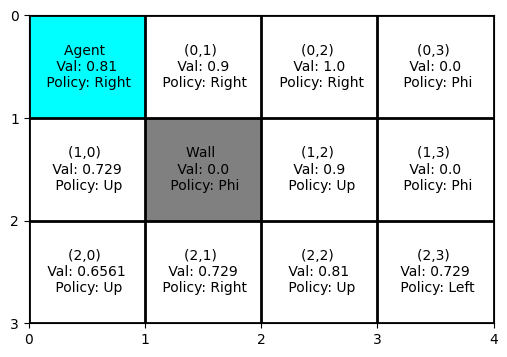

In [24]:
A.State.show_grid(optimal_values, optimal_policy)